This notebook replicates the simple inverse problems for Mixture Density Networks (MDNs) [Bishop 94].

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

First we set some parameters, make our data as in the paper, and define a helper function for making
a fully-connected layer.

In [11]:
input_dim = 1
output_dim = 1
n_samples = 3000

# x is a function of t. Inverse problem: t as a function of x
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, n_samples))).T
r_data = np.float32(np.random.normal(size=(n_samples, 1)))
t_data = np.float32(np.sin(0.75 * x_data) * 7.0 + x_data * 0.5 + r_data * 1.0)
temp_data = x_data
x_data = t_data
t_data = temp_data

n_gaussians = 24 # number of mixtures
MDN_out_dim = (output_dim + 2) * n_gaussians # number mixture outputs (as in paper)
batch_size = 120 # for training
n_hidden = 40

# shorthands
c = output_dim
NG = n_gaussians
constant = 1.0 / np.power(2*np.pi, c/2.0) # normal dist normalization constant

def dense(name, inputs, n_outputs):
    with tf.name_scope(name):
        n_inputs = inputs.get_shape().as_list()[1]
        weights = tf.Variable(tf.truncated_normal([n_inputs, n_outputs], 
                                                  stddev=0.1))
        biases = tf.Variable(tf.zeros([n_outputs]))
        return tf.matmul(inputs, weights) + biases

Now we construct the computational graph of an MDN. A network with one hidden layer spits out the mixture 
distribution parameters. The output layer of this network has activations applied to it according to the paper.

In [12]:
graph = tf.Graph()
with graph.as_default():
    
    data = tf.placeholder(tf.float32, shape=(None, input_dim))
    t = tf.placeholder(tf.float32, shape=(None, output_dim))
    h1 = dense("h1", inputs=data, n_outputs=n_hidden)
    h1 = tf.nn.relu(h1)
    out = dense("out", inputs=h1, n_outputs=MDN_out_dim)

    # split output layer and apply activations accordingly
    alpha_op = tf.slice(out, [0, 0], [-1, NG])
    alpha_op = tf.nn.softmax(alpha_op)
    sigma_op = tf.exp(tf.slice(out, [0, NG], [-1, NG]))
    mu_op = tf.slice(out, [0, 2*NG], [-1, -1])
    
    # reshape mu's and targets for further computation,
    # targets are replicated for each mixture component
    reshape_mu = tf.reshape(mu_op, (-1, NG, output_dim))
    reshape_t = tf.reshape(tf.tile(t, [1, NG]), (-1, NG, output_dim))
    
    # evaluate the multivariate pdfs defined by the parameters above 
    # on the target data
    sub = tf.sub(reshape_mu, reshape_t)
    squares = tf.square(sub)
    norm_sq = tf.reduce_sum(squares, reduction_indices=2)
    inv_sigma_sq = tf.inv(tf.square(sigma_op))
    div = -0.5 * tf.mul(norm_sq, inv_sigma_sq)
    sigma_pow = tf.pow(sigma_op, c)
    final = constant * tf.mul(tf.exp(div), tf.inv(sigma_pow))

    # compute the loss defined by the mean of the negative
    # log-likelihood. 
    weighted = tf.mul(final, alpha_op)
    prob = tf.reduce_sum(weighted, reduction_indices=1)
    logprob = -tf.log(prob)
    loss = tf.reduce_mean(logprob)

    optimizer = tf.train.AdamOptimizer().minimize(loss)

    init = tf.initialize_all_variables()

There's a bunch of math going on in the graph above to get the loss. Let's check that this is computed correctly by comparing it to the loss computed in regular numpy.

In [13]:
def numpy_loss(t, alpha, sigma, mu):
    from scipy.stats import multivariate_normal
    logprob = []
    for i in range(t.shape[0]):
        prob = 0
        for j in range(n_gaussians):
            mean = mu[i, j, :]
            cov = np.diag([sigma[i, j] ** 2] * output_dim)
            prob += alpha[i, j] * multivariate_normal.pdf(t[i], mean=mean, cov=cov)
        logprob.append(np.log(prob))
    return np.mean(-1 * np.array(logprob))

session = tf.Session(graph=graph)
session.run(init)

l, _, mu, alpha, sigma = session.run([loss, optimizer, reshape_mu, alpha_op, sigma_op],
                                     feed_dict={data:x_data, t:t_data})
print(l, numpy_loss(t_data, alpha, sigma, mu))
l, _, mu, alpha, sigma = session.run([loss, optimizer, reshape_mu, alpha_op, sigma_op],
                                     feed_dict={data:x_data, t:t_data})
print(l, numpy_loss(t_data, alpha, sigma, mu))
session.close()

12.2827 12.2826751906
12.0771 12.077052697


Now let's train the network on our data and plot our loss:

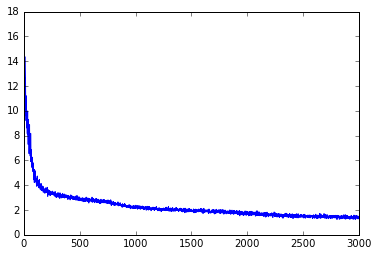

In [17]:
session = tf.Session(graph=graph)
session.run(init)

iterations = 3000
all_loss = []

for i in range(iterations):
    indices = np.random.choice(n_samples, size=batch_size, replace=False)
    batch_x = x_data[indices]
    batch_t = t_data[indices]
    l, _ = session.run([loss, optimizer], feed_dict={data:batch_x, t:batch_t})
    all_loss.append(l)

plt.plot(all_loss, '-')
plt.show()

To see what the network has learnt, we can take a look a the distribution it approximates by following these steps: (1) get the distribution parameters for each value of x,
(2) pick a mixture component to sample a target from according to the $\alpha$ distribution, and (3) sample a target from that component.

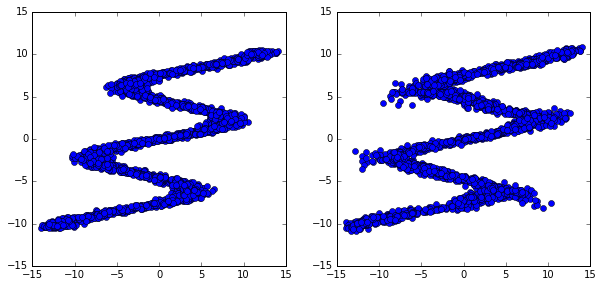

In [18]:
mu, alpha, sigma = session.run([mu_op, alpha_op, sigma_op], feed_dict={data:x_data})

samples = np.zeros((n_samples, output_dim))

plt.figure(figsize=(10,10))
plt.subplot(121, adjustable='box', aspect=1)
plt.plot(x_data, t_data, "o")

for i in range(n_samples):
    alpha_idx = np.random.choice(NG, size=1, p=alpha[i])[0]
    s_sigma = sigma[i, alpha_idx]
    mu_idx = alpha_idx * output_dim
    s_mu = mu[i, mu_idx:mu_idx + output_dim]
    cov = np.diag([s_sigma ** 2] * output_dim)
    samples[i, :] =  np.random.multivariate_normal(s_mu, cov)

plt.subplot(122, adjustable='box', aspect=1)
plt.plot(x_data, samples, "o")
plt.show()